In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any

# Preprocess

In [104]:
# read csv file to dataframe
def read_csv(path):
  columns = ["n", "sep", "mass", "fcon", "delta", "g", "rball", "offset", "dt", "maxiter", "time",
    "PAPI_TOT_INS", 
    "PAPI_TOT_CYC",
    "PAPI_L1_DCM",
    "PAPI_L3_TCA",
    "PAPI_L3_TCM",
    "PAPI_L2_DCM",
    "PAPI_L2_DCA",
    "PAPI_BR_MSP",
    "PAPI_BR_CN"]
  df = pd.read_csv(path, names=columns, sep=",", header=None)
  # specify dtypes to each column
  df = df.astype({"n": int, "sep": float, "mass": float, "fcon": float, "delta": int, "g": float, "rball": float, "offset": float, "dt": float, "maxiter": int, "time": np.int64,
    "PAPI_TOT_INS": np.int64, 
    "PAPI_TOT_CYC": np.int64,
    "PAPI_L1_DCM": np.int64,
    "PAPI_L3_TCA": np.int64,
    "PAPI_L3_TCM": np.int64,
    "PAPI_L2_DCM": np.int64,
    "PAPI_L2_DCA": np.int64,
    "PAPI_BR_MSP": np.int64,
    "PAPI_BR_CN": np.int64})
  return df

def params_to_arg_string(params):
  # convert params to arg string
  arg_string = ""
  for key, value in params.items():
    arg_string += str(key) + "=" + str(value) + ","
  arg_string = arg_string[:-1]
  return arg_string

def select_with_ns(df: pd.DataFrame, params: dict):
  arg_string = params_to_arg_string(params)
  df = df[df["args"].endswith(arg_string)]
  return df

def preprocess(df: pd.DataFrame):
  # calculate the L1 miss rate
  df["L1_miss_rate"] = df["PAPI_L1_DCM"] / df["PAPI_TOT_INS"]  
  # calculate the L2 miss rate
  df["L2_miss_rate"] = df["PAPI_L2_DCM"] / df["PAPI_L1_DCM"]
  # calculate the L3 miss rate
  df["L3_miss_rate"] = df["PAPI_L3_TCM"] / df["PAPI_L3_TCA"]
  # calculate the branch misprediction rate
  df["branch_misprediction_rate"] = df["PAPI_BR_MSP"] / df["PAPI_BR_CN"]
  # calculate the IPC
  df["IPC"] = df["PAPI_TOT_INS"] / df["PAPI_TOT_CYC"]
  # calculate the GFLOPS
  df["GFLOPS"] = df["PAPI_TOT_INS"] / df["time"] * 1e-9
  
  df["test"] = df["time"] / df["PAPI_TOT_CYC"]
  return df

def calculate_speedup(df: pd.DataFrame):
  # get the first ten rows of the dataframe
  baseline = df.head(10)
  # calculate the speedup
  df["speedup"] = baseline["time"].mean() / df["time"]
  df["p"] = df.index // 10 + 1
  return df

# Plot function


In [208]:
def plot_vs_n(ds: List[dict], column_name: str):
  # in each dict: exe_name: str, df_mean: pd.DataFrame, df_quantile: pd.DataFrame
  plt.figure(figsize=(10, 8))
  plt.title(f"{column_name} vs n")
  plt.xlabel("n")
  plt.ylabel(f"{column_name}")
  plt.grid(True)
  for d in ds:
    exe_name, df_mean, df_quantile = d["exe_name"], d["df_mean"], d["df_quantile"]
    plt.plot(df_mean[column_name], label=exe_name)
    plt.fill_between(df_mean.index, df_quantile[column_name].loc[:, 0.1], df_quantile[column_name].loc[:, 0.9], alpha=0.2)
  plt.legend()
  names = ",".join([d["exe_name"] for d in ds])
  plt.savefig(f"{names}_{column_name}_vs_n.png")
  plt.close()

def plot_vs_d(ds: List[dict], column_name: str):
    # in each dict: exe_name: str, df_mean: pd.DataFrame, df_quantile: pd.DataFrame
  plt.figure(figsize=(10, 8))
  plt.title(f"{column_name} vs d")
  plt.xlabel("d")
  plt.ylabel(f"{column_name}")
  plt.grid(True)
  for d in ds:
    exe_name, df_mean, df_quantile = d["exe_name"], d["df_mean"], d["df_quantile"]
    plt.plot(df_mean[column_name], label=exe_name)
    plt.fill_between(df_mean.index, df_quantile[column_name].loc[:, 0.1], df_quantile[column_name].loc[:, 0.9], alpha=0.2)
  plt.legend()
  names = ",".join([d["exe_name"] for d in ds])
  plt.savefig(f"{names}_{column_name}_vs_d.png")
  plt.close()

In [87]:
# params 
# ns = [20, 50, 80, 110, 140, 170, 200]
# ss = [1.0]
# ms = [1.0]
# fs = [10.0]
# ds = [2, 3, 4]
# gs = [0.981]
# bs = [1.0, 3.0]
# oos = [3.0, 5.0]
# ts = [0.05]
# iis = [200, 400]

# read csv file to dataframe
main_df = read_csv("main.csv")
opt_df = read_csv("opt.csv")
# sse_df = read_csv("sse.csv")
# vect_omp_df = read_csv("vect_omp.csv")
# omp_df = read_csv("omp.csv")

### Comparing main and opt version

#### Compare elapsed time

In [182]:
main_df = read_csv("main.csv")
opt_df = read_csv("opt.csv")
sse_df = read_csv("sse.csv")
vect_df = read_csv("vect_omp.csv")

main_df = preprocess(main_df)
opt_df = preprocess(opt_df)
sse_df = preprocess(sse_df)
vect_df = preprocess(vect_df)

main_mean_df = main_df.groupby("n").mean()
main_quantile_df = main_df.groupby("n").quantile([0.1, 0.9])
opt_mean_df = opt_df.groupby("n").mean()
opt_quantile_df = opt_df.groupby("n").quantile([0.1, 0.9])
sse_mean_df = sse_df.groupby("n").mean()
sse_quantile_df = sse_df.groupby("n").quantile([0.1, 0.9])

vect_mean_df = vect_df.groupby("n").mean()
vect_quantile_df = vect_df.groupby("n").quantile([0.1, 0.9])

columns_to_comp = ["time", "L1_miss_rate", "L2_miss_rate", "L3_miss_rate", "branch_misprediction_rate", "PAPI_BR_MSP", "IPC", "GFLOPS", "PAPI_TOT_CYC", "test", "PAPI_TOT_INS", "PAPI_L1_DCM"]

for c in columns_to_comp:
  plot_vs_n([
    {"exe_name": "main", "df_mean": main_mean_df, "df_quantile": main_quantile_df}, 
    {"exe_name": "opt", "df_mean": opt_mean_df, "df_quantile": opt_quantile_df}, 
    {"exe_name": "sse", "df_mean": sse_mean_df, "df_quantile": sse_quantile_df}, 
    {"exe_name": "vect", "df_mean": vect_mean_df, "df_quantile": vect_quantile_df}
  ], c)
  


#### Elapsed time with increase number of threads

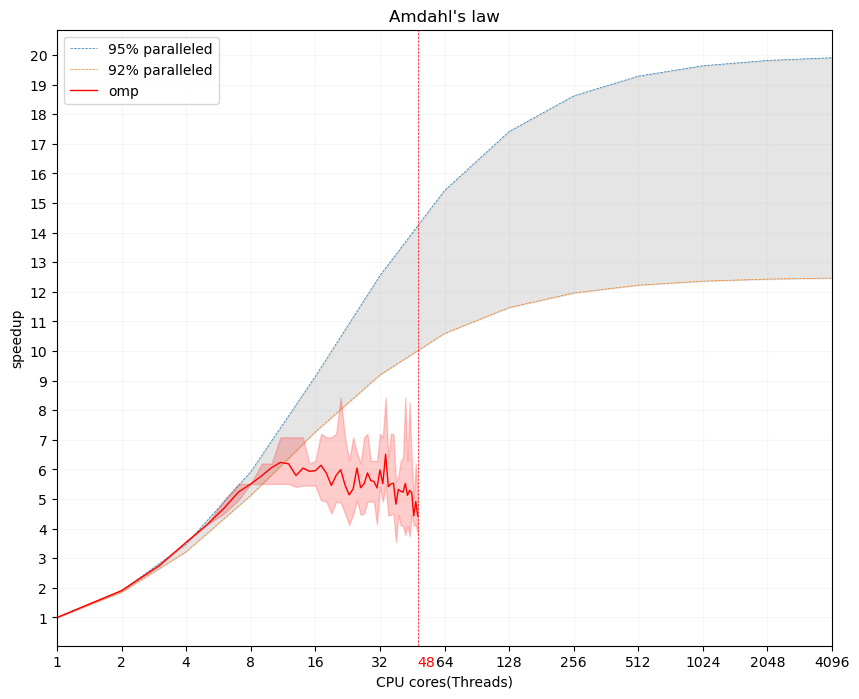

In [186]:
# '-n', '1000', '-s', '1.0', '-m', '1.0', '-f', '10.0', '-d', '2', '-g', '0.981', '-b', '3.0', '-o', '3.0', '-t', '0.05', '-i', '400', '-p', 1 ~ 48

def amdahl(p, N):
  return 1.0 / ((1 - p) + p / N)

omp_t_df = read_csv("omp_with_threads_48.csv")
omp_t_df = preprocess(omp_t_df)
omp_t_df = calculate_speedup(omp_t_df)

ox = np.log2(np.arange(1, 49))
y = omp_t_df.groupby("p")["speedup"].mean()
y_quantile = omp_t_df.groupby("p")["speedup"].quantile([0.1, 0.9])
x = np.array([i for i in range(13)])

xx = np.power(2.0, x)
plt.figure(figsize=(10, 8))
plt.title("Amdahl's law")
plt.xlabel("CPU cores(Threads)")
plt.ylabel("speedup")
plt.xticks(x, [str(2**i) for i in x])
plt.grid(True, alpha=0.1)
plt.xlim(0, 12)
plt.yticks(np.arange(0, 21))

# plot Amdahl's law
upper = amdahl(0.95, xx)
lower = amdahl(0.92, xx)
plt.plot(x, upper, linestyle='dashed', label="95% paralleled", linewidth=0.5)
plt.plot(x, lower, linestyle='dashed',label="92% paralleled",linewidth=0.5)
# plt.plot(x, amdahl(0.95, xx), linestyle='--', label="95%",linewidth=0.5)
plt.fill_between(x, lower, upper, alpha=0.2, color="gray")

plt.plot(ox, y, label="omp", linewidth=1.0, color="red")
plt.fill_between(ox, y_quantile.loc[:, 0.1], y_quantile.loc[:, 0.9], alpha=0.2, color="red")

# add vertical line at x=8
plt.axvline(x=np.log2(48), linestyle='dashed', color="red", linewidth=0.5)
# add x label at x=8
plt.text(np.log2(48), -0.65, "48", color="red", fontsize=10)
plt.legend()
plt.savefig("speedup_vs_p_48.png")
plt.show()


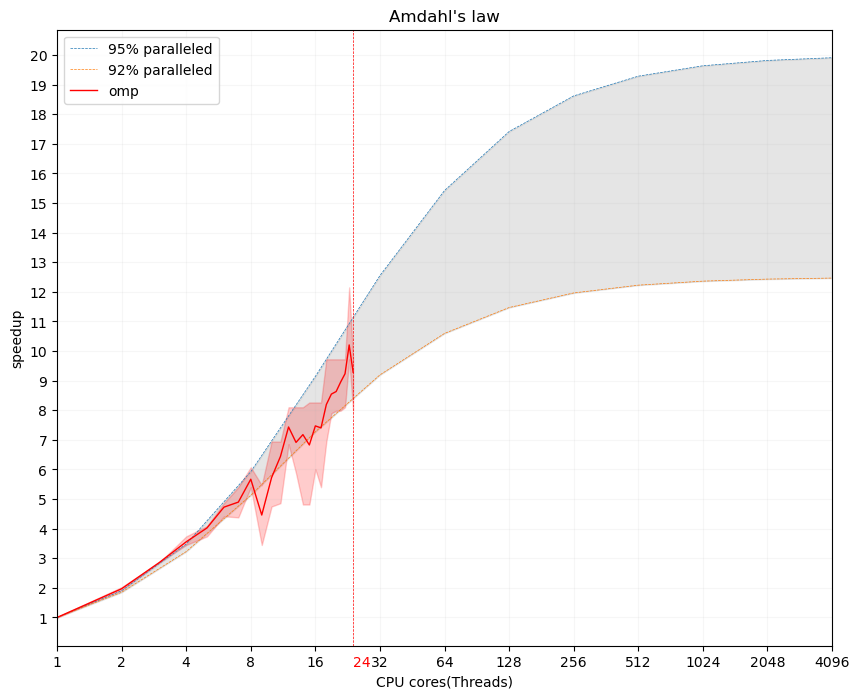

In [184]:
# '-n', '1000', '-s', '1.0', '-m', '1.0', '-f', '10.0', '-d', '2', '-g', '0.981', '-b', '3.0', '-o', '3.0', '-t', '0.05', '-i', '400', '-p', 1 ~ 24

def amdahl(p, N):
  return 1.0 / ((1 - p) + p / N)

omp_t_df = read_csv("omp_with_threads.csv")
omp_t_df = preprocess(omp_t_df)
omp_t_df = calculate_speedup(omp_t_df)

ox = np.log2(np.arange(1, 25))
y = omp_t_df.groupby("p")["speedup"].mean()
y_quantile = omp_t_df.groupby("p")["speedup"].quantile([0.1, 0.9])
x = np.array([i for i in range(13)])

xx = np.power(2.0, x)
plt.figure(figsize=(10, 8))
plt.title("Amdahl's law")
plt.xlabel("CPU cores(Threads)")
plt.ylabel("speedup")
plt.xticks(x, [str(2**i) for i in x])
plt.grid(True, alpha=0.1)
plt.xlim(0, 12)
plt.yticks(np.arange(0, 21))

# plot Amdahl's law
upper = amdahl(0.95, xx)
lower = amdahl(0.92, xx)
plt.plot(x, upper, linestyle='dashed', label="95% paralleled", linewidth=0.5)
plt.plot(x, lower, linestyle='dashed',label="92% paralleled",linewidth=0.5)
# plt.plot(x, amdahl(0.95, xx), linestyle='--', label="95%",linewidth=0.5)
plt.fill_between(x, lower, upper, alpha=0.2, color="gray")

plt.plot(ox, y, label="omp", linewidth=1.0, color="red")
plt.fill_between(ox, y_quantile.loc[:, 0.1], y_quantile.loc[:, 0.9], alpha=0.2, color="red")

# add vertical line at x=8
plt.axvline(x=np.log2(24), linestyle='dashed', color="red", linewidth=0.5)
# add x label at x=8
plt.text(np.log2(24), -0.65, "24", color="red", fontsize=10)
plt.legend()
plt.savefig("speedup_vs_p.png")
plt.show()


#### OMP performance with same $n^2 p^2$
Compare three combination:
- 1000, 2
- 500,  4
- 250,  8

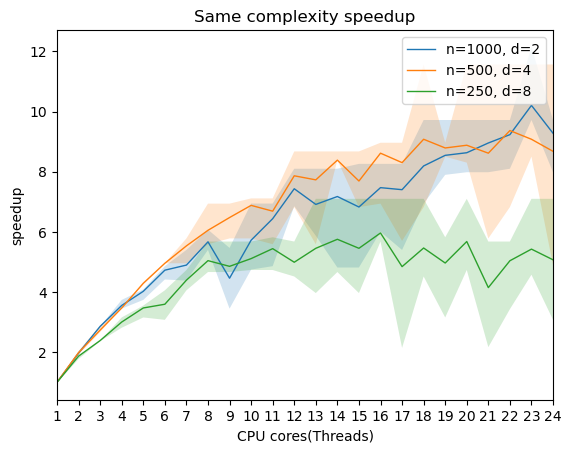

In [192]:
omp_1000_2_df = read_csv("omp_1000_2.csv")
omp_1000_2_df = preprocess(omp_1000_2_df)
omp_1000_2_df = calculate_speedup(omp_1000_2_df)

omp_500_4_df = read_csv("omp_500_4.csv")
omp_500_4_df = preprocess(omp_500_4_df)
omp_500_4_df = calculate_speedup(omp_500_4_df)

omp_250_8_df = read_csv("omp_250_8.csv")
omp_250_8_df = preprocess(omp_250_8_df)
omp_250_8_df = calculate_speedup(omp_250_8_df)

# plot three speedup vs p
ox = np.arange(1, 25)
y1 = omp_1000_2_df.groupby("p")["speedup"].mean()
y1_quantile = omp_1000_2_df.groupby("p")["speedup"].quantile([0.1, 0.9])

y2 = omp_500_4_df.groupby("p")["speedup"].mean()
y2_quantile = omp_500_4_df.groupby("p")["speedup"].quantile([0.1, 0.9])

y3 = omp_250_8_df.groupby("p")["speedup"].mean()
y3_quantile = omp_250_8_df.groupby("p")["speedup"].quantile([0.1, 0.9])

plt.plot(ox, y1, label="n=1000, d=2", linewidth=1.0)
plt.fill_between(ox, y1_quantile.loc[:, 0.1], y1_quantile.loc[:, 0.9], alpha=0.2)

plt.plot(ox, y2, label="n=500, d=4", linewidth=1.0)
plt.fill_between(ox, y2_quantile.loc[:, 0.1], y2_quantile.loc[:, 0.9], alpha=0.2)

plt.plot(ox, y3, label="n=250, d=8", linewidth=1.0)
plt.fill_between(ox, y3_quantile.loc[:, 0.1], y3_quantile.loc[:, 0.9], alpha=0.2)
plt.xlim(1, 24)
plt.xticks(ox)
plt.title("Same complexity speedup")
plt.xlabel("CPU cores(Threads)")
plt.ylabel("speedup")
plt.legend()
plt.savefig("same_complexity_speedup_vs_p.png")
plt.show()
# x = np.array([i for i in range(13)])


#### OMP performance with different chunksize: 1 10 default

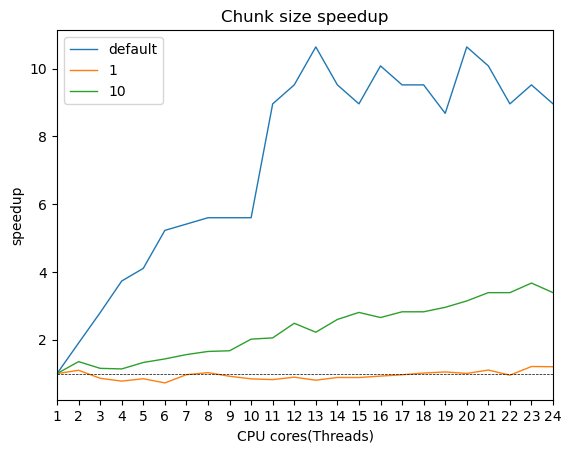

In [204]:
c_default_df = read_csv("omp_chunk_default.csv")
c_1_df = read_csv("omp_chunk_1.csv")
c_10_df = read_csv("omp_chunk_10.csv")

c_default_df = preprocess(c_default_df)
c_default_df = calculate_speedup(c_default_df)

c_1_df = preprocess(c_1_df)
c_1_df = calculate_speedup(c_1_df)

c_10_df = preprocess(c_10_df)
c_10_df = calculate_speedup(c_10_df)

# plot three speedup vs p
ox = np.arange(1, 25)
y1 = c_default_df.groupby("p")["speedup"].mean()
y1_quantile = c_default_df.groupby("p")["speedup"].quantile([0.25, 0.75])

y2 = c_1_df.groupby("p")["speedup"].mean()
y2_quantile = c_1_df.groupby("p")["speedup"].quantile([0.1, 0.9])

y3 = c_10_df.groupby("p")["speedup"].mean()
y3_quantile = c_10_df.groupby("p")["speedup"].quantile([0.1, 0.9])

plt.plot(ox, y1, label="default", linewidth=1.0)
# plt.fill_between(ox, y1_quantile.loc[:, 0.75], y1_quantile.loc[:, 0.25], alpha=0.2)

plt.plot(ox, y2, label="1", linewidth=1.0)
# plt.fill_between(np.arange(1, len(y2) + 1), y2_quantile.loc[:, 0.1], y2_quantile.loc[:, 0.9], alpha=0.2)

plt.plot(ox, y3, label="10", linewidth=1.0)
# plt.fill_between(ox, y3_quantile.loc[:, 0.1], y3_quantile.loc[:, 0.9], alpha=0.2)

# draw horizontal line at y=1
plt.axhline(y=1, linestyle='dashed', color="black", linewidth=0.5)
# todo set ylim
plt.xlim(1, 24)
plt.xticks(ox)
plt.title("Chunk size speedup")
plt.xlabel("CPU cores(Threads)")
plt.ylabel("speedup")
plt.legend()
plt.savefig("chunk_size_speedup_vs_p.png")
plt.show()